# Packages

In [1]:
from __future__ import print_function
import os
import time
import numpy as np
import tensorflow as tf
import scipy.io
import scipy.misc
import imageio
import random
#import cv2
from six.moves import urllib
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


# Other Functions

In [3]:
def download(download_link, file_name, expected_bytes):
    if os.path.exists(file_name):
        print("model net already download, model ready")
        return
    print("Downloading the pre-trained model. This might take a while ...")
    file_name, _ = urllib.request.urlretrieve(download_link, file_name)
    file_stat = os.stat(file_name)
    if file_stat.st_size == expected_bytes:
        print('Successfully downloaded pre-trained model', file_name)
    else:
        raise Exception('File ' + file_name +
                        ' might be corrupted. You should try downloading it with a browser.')

def get_resized_image(img_path, height, width, save=True):
    image = Image.open(img_path)
    # it's because PIL is column major so you have to change place of width and height
    # this is stupid, i know
    image = ImageOps.fit(image, (width, height), Image.ANTIALIAS)
    if save:
        image_dirs = img_path.split('/')
        image_dirs[-1] = 'resized_' + image_dirs[-1]
        out_path = '/'.join(image_dirs)
        if not os.path.exists(out_path):
            image.save(out_path)
    image = np.asarray(image, np.float32)
    return np.expand_dims(image, 0)

def generate_noise_image(content_image, height, width, noise_ratio=0.6):
    noise_image = np.random.uniform(-20, 20, (1, height, width, 3)).astype(np.float32)
    return noise_image * noise_ratio + content_image * (1 - noise_ratio)

def save_image(path, image):
    # Output should add back the mean pixels we subtracted at the beginning
    image = image[0] # the image
    image = np.clip(image, 0, 255).astype('uint8')
    #scipy.misc.imsave(path, image)
    imageio.imwrite(path, image)

def make_dir(path):
    try:
        os.mkdir(path)
    except OSError:
        pass

In [4]:
#This function plots the content-, mixed- and style-images.
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
def load_image(filename, max_size=None):
    image = Image.open(filename)

    if max_size is not None:
        # Calculate the appropriate rescale-factor for
        # ensuring a max height and width, while keeping
        # the proportion between them.
        factor = max_size / np.max(image.size)
    
        # Scale the image's height and width.
        size = np.array(image.size) * factor

        # The size is now floating-point because it was scaled.
        # But PIL requires the size to be integers.
        size = size.astype(int)

        # Resize the image.
        image = image.resize(size, Image.LANCZOS)

    # Convert to numpy floating-point array.
    return np.float32(image)

# Neural Network Layers

In [5]:
def _weights(trained_layers, layer_idx, expected_layer_name):
    """ Return the weights and biases already trained by the net """
    W = trained_layers[0][layer_idx][0][0][2][0][0]
    b = trained_layers[0][layer_idx][0][0][2][0][1]
    layer_name = trained_layers[0][layer_idx][0][0][0][0]
    
    assert layer_name == expected_layer_name
    
    #if (layer_idx == 0): put this in comment to fix for laoding alex net
    b = b.reshape(b.size)
        
    return W, b


def _conv2d_relu_2(trained_layers, prev_layer, layer_idx, layer_name, s_h, s_w, group, padding='SAME'):
    """
    Adapted from: https://github.com/ethereon/caffe-tensorflow
    """
    with tf.compat.v1.variable_scope(layer_name) as scope:
        w, b = _weights(trained_layers, layer_idx, layer_name)
        w = tf.constant(w, name='weights')
        b = tf.constant(b, name='bias')
        
        convolve = lambda inputs, weigths: tf.nn.conv2d(inputs, weigths, [1, s_h, s_w, 1], padding=padding)
    
        if group==1:
            conv2d = convolve(prev_layer, w)
        else:
            # Split input and weights and conv2d them separately
            input_groups = tf.split(prev_layer, group, 3)
            kernel_groups = tf.split(w, group, 3)
            output_groups = [tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)
                             for i, k in zip(input_groups, kernel_groups)]
            conv2d = tf.concat(output_groups, 3)
            
        conv_lin = tf.reshape(tf.nn.bias_add(conv2d, b), [-1] + conv2d.get_shape().as_list()[1:], name='lin')
        conv_relu = tf.nn.relu(conv_lin, name='relu')

        return conv_relu

    
def _maxpool(prev_layer, layer_name):
    return tf.nn.max_pool(prev_layer, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID', name=layer_name)

def _avgpool(prev_layer, layer_name):
    return tf.nn.avg_pool(prev_layer, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID', name=layer_name)

def _lrn(prev_layer, layer_name):        
    return tf.nn.local_response_normalization(prev_layer, depth_radius=2, alpha=2e-05, beta=0.75,bias=1.0,name=layer_name)


def load_net_from_file(path, input_image):
    """ Load net into a TensorFlow model. Use a dictionary to hold the model instead of using a Python class """
    net = scipy.io.loadmat(path)
    trained_layers = net['layers']
   
    graph = {} 
    graph['conv1']  = _conv2d_relu_2(trained_layers , input_image, 0, 'conv1', s_h=4, s_w=4, group=1)
    graph['norm1']  = _lrn(graph['conv1'], 'norm1')
    graph['pool1']  = _maxpool(graph['norm1'], 'pool1')
    
    graph['conv2']  = _conv2d_relu_2(trained_layers, graph['pool1'], 4, 'conv2', s_h=1, s_w=1, group=2)
    graph['norm2']  = _lrn(graph['conv2'], 'norm2')
    graph['pool2']  = _maxpool(graph['norm2'], 'pool2')
    
    graph['conv3']  = _conv2d_relu_2(trained_layers, graph['pool2'], 8, 'conv3', s_h=1, s_w=1, group=1)
    graph['conv4']  = _conv2d_relu_2(trained_layers, graph['conv3'], 10, 'conv4', s_h=1, s_w=1, group=2)
    graph['conv5']  = _conv2d_relu_2(trained_layers, graph['conv4'], 12, 'conv5', s_h=1, s_w=1, group=2)    
    
    return graph

In [6]:
DOWNLOAD_LINK = 'http://www.vlfeat.org/matconvnet/models/imagenet-caffe-alex.mat'
File_MODEL_PATH = 'imagenet-caffe-alex.mat'
EXPECTED_BYTES = 228041398   

MODEL_NET_NAME = 'Alexnet_Style_Transfer_results/alexnet'   #根路径
OUTPUT_PATH = MODEL_NET_NAME + '_outputs'            #合成图片输出路径
CHECKPOINT_PATH = MODEL_NET_NAME + '_checkpoints'    #训练节点输出路径
GRAPHS_PATH = MODEL_NET_NAME + '_graphs'            #网络输出路径

#定义读取内容图像和风格图像的路径

mylist = os.listdir('./Test_dataset')
root_path = './Test_dataset/'

random.seed(1)
CONTENT_IMAGE_PATH = root_path + random.choice(mylist) 



STYLE_IMAGE_PATH = './Alexnet_Style_Transfer_results/style_input/Van_Gogh_starry_sky.jpg'

#CONTENT_IMAGE_PATH = './Alexnet_Style_Transfer_results/content_input/content1.jpg'

img_original = Image.open(CONTENT_IMAGE_PATH)  #读取内容图像表示的二维矩阵

IMAGE_HEIGHT = img_original.height  #将生成图像的长和宽与原内容图像保持一致
IMAGE_WIDTH = img_original.width

CONTENT_WEIGHT = 0.01   #内容图像权重
STYLE_WEIGHT = 1       #风格图像权重

NOISE_RATIO = 0.6     #白噪声与原内容图像混合的比例

ITERS = 200           #迭代次数
LR = 2.0              #固定学习率

# starter_learning_rate = 2.0
#使用学习率梯度下降的方式；参数为学习率初始值，全局迭代步数，衰减速度，衰减率，阶梯下降，名称
# LR =tf.compat.v1.train.exponential_decay(starter_learning_rate,ITERS,50,0.8,staircase=True)

#LR = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=25, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)



# optimizer = torch.optim.Adam(model.parameters(),lr=5.0,momentum=0.9)
# base_lr = 2e-3
# max_lr = 6e-3

# torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, 
# 							step_size_up = 100,
# 							step_size_down=None, mode='triangular', gamma=1.0, scale_fn=None, 
# 							scale_mode='cycle', cycle_momentum=True, base_momentum=0.8,
# 							max_momentum=0.9, last_epoch=-1)






# 指定用于风格特征的网络层
STYLE_LAYERS = ['conv1', 'conv3', 'conv4', 'conv5']
#越深的层数指定更大的权重
W = [0.1, 0.2, 0.3, 0.4] 

# 指定用于内容特征的网络层
CONTENT_LAYER = 'conv2'

#这里的数组是RGB通道固定数值
MEAN_PIXELS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))




def _create_content_loss(p, f):
    """ Calculate the loss between the feature representation of the
    content image and the generated image.
    
    Inputs: 
        p, f are just P, F in the paper 
        (read the assignment handout if you're confused)
        Note: we won't use the coefficient 0.5 as defined in the paper
        but the coefficient as defined in the assignment handout.
    Output:
        the content loss
    """
    return tf.reduce_sum((f - p) ** 2) / (4.0 * p.size)

def _gram_matrix(F, N, M):
    """ Create and return the gram matrix for tensor F
        Hint: you'll first have to reshape F
    """
    F = tf.reshape(F, (M, N))
    return tf.matmul(tf.transpose(F), F)

def _single_style_loss(a, g):
    """ Calculate the style loss at a certain layer
    Inputs:
        a is the feature representation of the real image
        g is the feature representation of the generated image
    Output:
        the style loss at a certain layer (which is E_l in the paper)

    Hint: 1. you'll have to use the function _gram_matrix()
        2. we'll use the same coefficient for style loss as in the paper
        3. a and g are feature representation, not gram matrices
    """
    N = a.shape[3] # number of filters
    M = a.shape[1] * a.shape[2] # height times width of the feature map
    A = _gram_matrix(a, N, M)
    G = _gram_matrix(g, N, M)
    
    return tf.reduce_sum((G - A) ** 2 / ((2 * N * M) ** 2))

def _create_style_loss(A, model):
    """ Return the total style loss """
    n_layers = len(STYLE_LAYERS)
    E = [_single_style_loss(A[i], model[STYLE_LAYERS[i]]) for i in range(n_layers)]
    
    return sum([W[i] * E[i] for i in range(n_layers)])
    
    
def _create_losses(model, input_image, content_image, style_image):
    with tf.compat.v1.variable_scope('loss') as scope:
        with tf.compat.v1.Session() as sess:
            sess.run(input_image.assign(content_image)) # assign content image to the input variable
            p = sess.run(model[CONTENT_LAYER])
        content_loss = _create_content_loss(p, model[CONTENT_LAYER])

        with tf.compat.v1.Session() as sess:
            sess.run(input_image.assign(style_image))
            A = sess.run([model[layer_name] for layer_name in STYLE_LAYERS])                              
        style_loss = _create_style_loss(A, model)

        total_loss = CONTENT_WEIGHT * content_loss + STYLE_WEIGHT * style_loss
       
    return content_loss, style_loss, total_loss


def _create_summary(model):
    """ Create summary ops necessary Hint: don't forget to merge them """
    with tf.name_scope('summaries'):
        tf.summary.scalar('content loss', model['content_loss'])
        tf.summary.scalar('style loss', model['style_loss'])
        tf.summary.scalar('total loss', model['total_loss'])
        tf.summary.histogram('histogram content loss', model['content_loss'])
        tf.summary.histogram('histogram style loss', model['style_loss'])
        tf.summary.histogram('histogram total loss', model['total_loss'])
        return tf.compat.v1.summary.merge_all()

In [7]:
def train(model, generated_image, initial_image):
    """ Train your model. Don't forget to create folders for checkpoints and outputs. """
    skip_step = 1
    with tf.compat.v1.Session() as sess:
        
        saver = tf.compat.v1.train.Saver()
        sess.run(tf.compat.v1.global_variables_initializer())
        writer = tf.compat.v1.summary.FileWriter(GRAPHS_PATH, sess.graph)
        
        sess.run(generated_image.assign(initial_image))
        ckpt = tf.train.get_checkpoint_state(os.path.dirname(CHECKPOINT_PATH))
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
        initial_step = model['global_step'].eval()
        
        start_time = time.time()
        for index in range(initial_step, ITERS):
            if index >= 5 and index < 20:
                skip_step = 10
            elif index >= 20:
                skip_step = 20
            
            sess.run(model['optimizer'])
            if (index + 1) % skip_step == 0:
                gen_image, total_loss, summary = sess.run([generated_image, model['total_loss'], 
                                                             model['summary_op']])
                gen_image = gen_image + MEAN_PIXELS
                writer.add_summary(summary, global_step=index)
                print('Step {}\n   Sum: {:5.1f}'.format(index + 1, np.sum(gen_image)))
                print('   Loss: {:5.1f}'.format(total_loss))
                print('   Time: {}'.format(time.time() - start_time))
                start_time = time.time()

                filename = OUTPUT_PATH + '/%d.png' % (index)
                
                save_image(filename, gen_image)
                
                #In larger resolution
                # Plot the content-, style- and mixed-images.
#                 c_image = load_image(BASE_CONTENT_IMAGE_PATH + 'resized_' + CONTENT_IMAGE_PATH,max_size=IMAGE_HEIGHT)
#                 s_image = load_image(BASE_STYLE_IMAGE_PATH + 'resized_' + STYLE_IMAGE_PATH,max_size=IMAGE_HEIGHT)
                c_image = load_image(CONTENT_IMAGE_PATH,max_size=IMAGE_HEIGHT)
                s_image = load_image(STYLE_IMAGE_PATH,max_size=IMAGE_HEIGHT)
                g_image = load_image(filename,max_size=IMAGE_HEIGHT)
                plot_images(content_image=c_image,style_image=s_image,mixed_image=g_image)
                
                if (index + 1) % 20 == 0:
                    saver.save(sess, CHECKPOINT_PATH + '/style_transfer', index)

In [8]:
def main():
    with tf.compat.v1.variable_scope('input') as scope:
        # use variable instead of placeholder because we're training the intial image to make it
        # look like both the content image and the style image
        input_image = tf.Variable(np.zeros([1, IMAGE_HEIGHT, IMAGE_WIDTH, 3]), dtype=tf.float32)
    
        download(DOWNLOAD_LINK, File_MODEL_PATH, EXPECTED_BYTES)
        
    make_dir(CHECKPOINT_PATH)
    make_dir(OUTPUT_PATH)
    
    model = load_net_from_file(File_MODEL_PATH, input_image)
    model['global_step'] = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

    #content_image = get_resized_image(BASE_CONTENT_IMAGE_PATH + CONTENT_IMAGE_PATH, IMAGE_HEIGHT, IMAGE_WIDTH)
    content_image = get_resized_image( CONTENT_IMAGE_PATH, IMAGE_HEIGHT, IMAGE_WIDTH)
    content_image = content_image - MEAN_PIXELS
    
    #style_image = get_resized_image(BASE_STYLE_IMAGE_PATH + STYLE_IMAGE_PATH, IMAGE_HEIGHT, IMAGE_WIDTH)
    style_image = get_resized_image(STYLE_IMAGE_PATH, IMAGE_HEIGHT, IMAGE_WIDTH)
    style_image = style_image - MEAN_PIXELS

    model['content_loss'], model['style_loss'], model['total_loss'] = _create_losses(model, input_image, content_image, style_image)
    
    model['optimizer'] = tf.compat.v1.train.AdamOptimizer(LR).minimize(model['total_loss'], global_step=model['global_step'])
    #model['optimizer'] = Adam(LR).minimize(model['total_loss'], global_step=model['global_step'])
    #model['optimizer'] = Adam(LR).minimize(model['total_loss'])
    
    model['summary_op'] = _create_summary(model)

    initial_image = generate_noise_image(content_image, IMAGE_HEIGHT, IMAGE_WIDTH, NOISE_RATIO)
    
    train(model, input_image, initial_image)

model net already download, model ready
INFO:tensorflow:Summary name content loss is illegal; using content_loss instead.
INFO:tensorflow:Summary name style loss is illegal; using style_loss instead.
INFO:tensorflow:Summary name total loss is illegal; using total_loss instead.
INFO:tensorflow:Summary name histogram content loss is illegal; using histogram_content_loss instead.
INFO:tensorflow:Summary name histogram style loss is illegal; using histogram_style_loss instead.
INFO:tensorflow:Summary name histogram total loss is illegal; using histogram_total_loss instead.
Step 1
   Sum: 98668671.3
   Loss: 545159.7
   Time: 1.1214282512664795


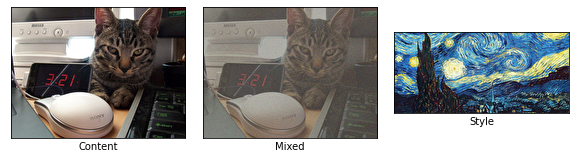

Step 2
   Sum: 98707253.8
   Loss: 534205.3
   Time: 0.939640998840332


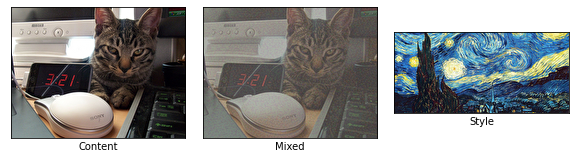

Step 3
   Sum: 98751361.0
   Loss: 520579.2
   Time: 0.9077370166778564


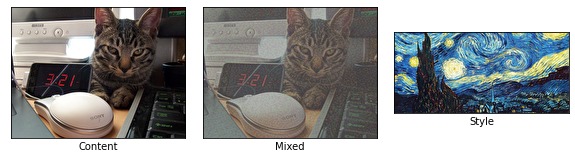

Step 4
   Sum: 98800709.4
   Loss: 504203.3
   Time: 0.8637807369232178


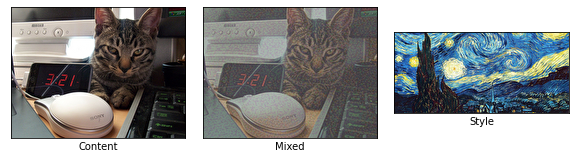

Step 5
   Sum: 98854779.2
   Loss: 485035.8
   Time: 0.8866698741912842


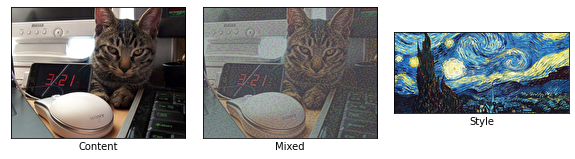

Step 10
   Sum: 99185908.9
   Loss: 349924.0
   Time: 1.6013576984405518


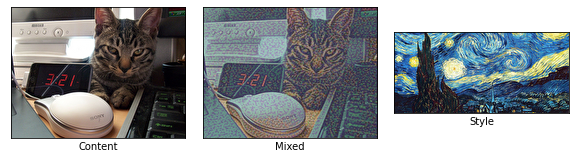

Step 20
   Sum: 100278598.2
   Loss: 49622.4
   Time: 2.6054840087890625


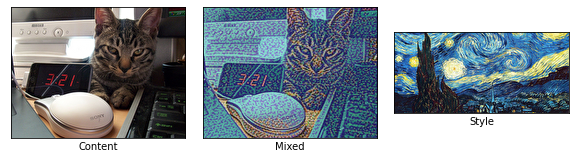

Step 40
   Sum: 101474395.8
   Loss: 7521.4
   Time: 4.741290092468262


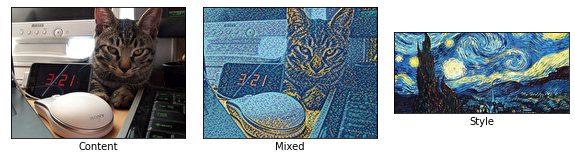

Step 60
   Sum: 101868797.4
   Loss: 4026.4
   Time: 4.831712007522583


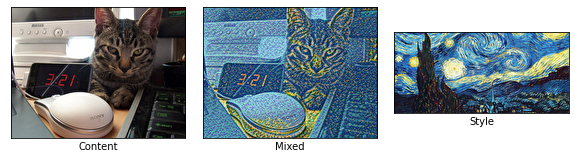

Step 80
   Sum: 102032901.8
   Loss: 1849.1
   Time: 4.63001823425293


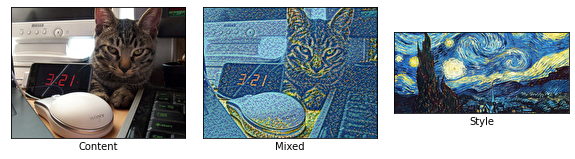

Step 100
   Sum: 102251392.2
   Loss: 1329.5
   Time: 4.723678112030029


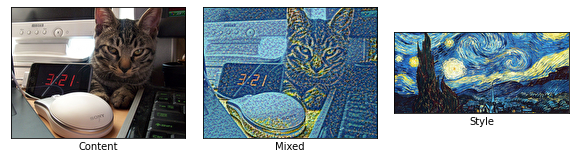

Step 120
   Sum: 102512035.9
   Loss: 1065.4
   Time: 4.8056581020355225


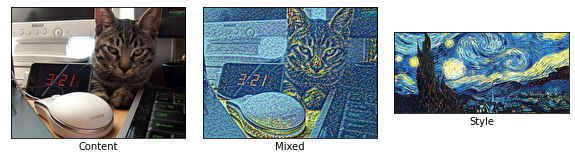

Instructions for updating:
Use standard file APIs to delete files with this prefix.
Step 140
   Sum: 102767332.4
   Loss: 888.3
   Time: 5.03739595413208


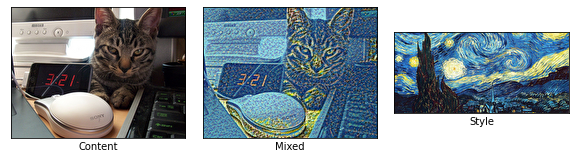

Step 160
   Sum: 103010111.0
   Loss: 757.9
   Time: 4.671473026275635


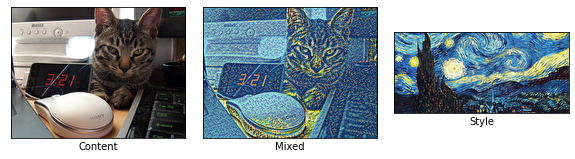

Step 180
   Sum: 103236200.9
   Loss: 658.2
   Time: 4.82288122177124


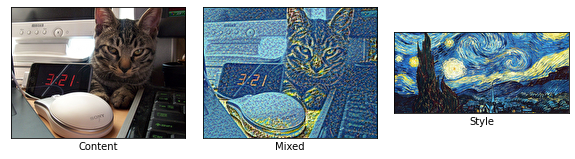

Step 200
   Sum: 103443869.9
   Loss: 579.7
   Time: 5.220494031906128


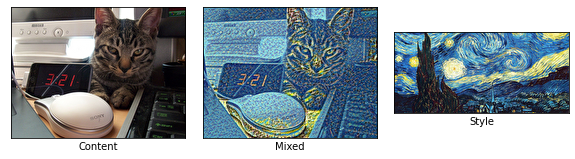

elapsed time: 00:00:56


In [9]:
start_time = time.time()

main()
    
end_time = time.time()
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(end_time - start_time))

print("elapsed time: %s" % elapsed_time)